In [210]:
import os
import re
import time
import json
import pickle
import signal
import logging
from datetime import datetime
from typing import Optional, Dict, Any, Tuple, Set, List
import PyPDF2


# Third-Party Library
from fuzzywuzzy import process, fuzz
import requests
from urllib3.util.retry import Retry
import pandas as pd
import numpy as np
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport


df = pd. read_csv(r"C:\Users\divya\OneDrive\Documents\GitHub\spring-2025-greenlight\Praneed(EDA&Preprocessing)\enriched_data.csv")
df = df.drop(columns=["final_genres", "final_runtime", "final_overview", "final_original_language", "final_rating", "final_production_countries", "cast", "crew", "director_id", "star_id","final_certificate" ], errors='ignore')
df = df.dropna(subset=['rating', 'genres', 'runtime'])

In [211]:
zero_budget = (df['final_budget'] == 0).sum()
zero_boxoffice = (df['final_worldwide_boxoffice'] == 0).sum()
zero_both_boxoffice = ((df['final_domestic_boxoffice'] == 0) & (df['final_worldwide_boxoffice'] == 0))
print(f"Zero budget values: {zero_budget}")
print(f"Zero worldwide box office values: {zero_boxoffice}")
print(f"Found {zero_both_boxoffice.sum()} rows where both domestic and worldwide box office are zero")
df = df[~zero_both_boxoffice]

invalid_revenue = df[df['final_worldwide_boxoffice'] < df['final_domestic_boxoffice']]
print(f"Found {len(invalid_revenue)} rows where worldwide < domestic box office")
if len(invalid_revenue) > 0:
    print(invalid_revenue[['final_title', 'final_year', 'final_domestic_boxoffice', 'final_worldwide_boxoffice']].head())

problematic_rows = df[df['final_worldwide_boxoffice'] < df['final_domestic_boxoffice']]
df = df.copy()
df.loc[problematic_rows.index, 'final_worldwide_boxoffice'] = df.loc[problematic_rows.index, 'final_domestic_boxoffice']

# Add a flag to identify corrected entries
df['boxoffice_corrected'] = 0
df.loc[problematic_rows.index, 'boxoffice_corrected'] = 1
df= df.copy()

Zero budget values: 0
Zero worldwide box office values: 270
Found 270 rows where both domestic and worldwide box office are zero
Found 226 rows where worldwide < domestic box office
             final_title  final_year  final_domestic_boxoffice  \
19          12 Angry Men      1957.0                 4360000.0   
119          42nd Street      1933.0                 2300000.0   
194      Ace in the Hole      1951.0                 3969893.0   
222            Admission      2013.0                18004225.0   
244  A Fish Called Wanda      1988.0                63493712.0   

     final_worldwide_boxoffice  
19                   1000000.0  
119                  2281000.0  
194                  1300000.0  
222                 18000000.0  
244                 62493712.0  


In [ ]:
def extract_bls_cpi_data(file_path, output_csv_path='bls_cpi_data.csv'):
    
    if file_path.lower().endswith('.pdf'):
        try:
            
            with open(file_path, 'rb') as file:
                reader = PyPDF2.PdfReader(file)
                text = ""
                for page in reader.pages:
                    text += page.extract_text() + "\n"
        except Exception as e:
            print(f"Error extracting text from PDF: {e}")
            return None
    else:
        try:
            with open(file_path, 'r', encoding='utf-8') as file:
                text = file.read()
        except Exception as e:
            print(f"Error reading file: {e}")
            return None
    
    cpi_data = {}
    annual_avg_pattern = r'(\d{4}).*?Annual\s+avg\.\s+(\d+\.\d+)'
    matches = re.findall(annual_avg_pattern, text)
    
    if matches:
        for year, cpi in matches:
            cpi_data[int(year)] = float(cpi)
    
    if not cpi_data:
        lines = text.split('\n')
        for line in lines:
            year_match = re.match(r'(\d{4}).*?(\d+\.\d+)$', line.strip())
            if year_match:
                year = int(year_match.group(1))
                december_cpi = float(year_match.group(2))
                cpi_data[year] = december_cpi
    
    if cpi_data:
        df = pd.DataFrame(list(cpi_data.items()), columns=['Year', 'Annual_avg'])
        df = df.sort_values('Year')
        df.to_csv(output_csv_path, index=False)
        print(f"Saved CPI data for {len(cpi_data)} years to {output_csv_path}")
        return cpi_data
    else:
        print("No CPI data found in the file")
        return None


def calculate_inflation_factors(cpi_data, base_year=2023):
 
    if not cpi_data:
        return None
    
    if base_year not in cpi_data:
        print(f"Base year {base_year} not in CPI data. Using most recent year instead.")
        base_year = max(cpi_data.keys())
    
    base_cpi = cpi_data[base_year]
    
    if base_cpi <= 0:
        print(f"Error: CPI value for base year {base_year} is zero or negative.")
        return None
    
    inflation_factors = {}
    for year, cpi in cpi_data.items():
        if cpi <= 0:
            print(f"Warning: Invalid CPI value {cpi} for year {year}. Skipping.")
            continue
        
        inflation_factors[year] = base_cpi / cpi
    
    # future years 
    current_year = 2025  # Current year 
    max_data_year = max(cpi_data.keys())
    
    if max_data_year < current_year:
      
        recent_factor = inflation_factors[max_data_year]
        
        # average annual change over last 3 years 
        if max_data_year > 2 and (max_data_year-2) in inflation_factors:
            prev_factor = inflation_factors[max_data_year-2]
            annual_change = (recent_factor - prev_factor) / 2
        else:
            annual_change = -0.03 / (current_year - max_data_year)
        
        for year in range(max_data_year + 1, current_year + 2):
            years_from_data = year - max_data_year
            projected_factor = recent_factor + (annual_change * years_from_data)
            
            if projected_factor <= 0:
                projected_factor = 0.9 
            
            inflation_factors[year] = projected_factor
            print(f"Projected inflation factor for {year}: {projected_factor:.3f}")
    
    return inflation_factors


extract_bls_cpi_data('bls_cpi_data.pdf', 'bls_cpi_data.csv')

Saved CPI data for 111 years to bls_cpi_data.csv


{1913: 10.0,
 1914: 1.0,
 1915: 1.0,
 1916: 7.9,
 1917: 17.4,
 1918: 18.0,
 1919: 14.6,
 1920: 15.6,
 1921: 10.5,
 1922: 6.1,
 1923: 1.8,
 1924: 0.0,
 1925: 2.3,
 1926: 1.1,
 1927: 1.7,
 1928: 1.7,
 1929: 0.0,
 1930: 2.3,
 1931: 9.0,
 1932: 9.9,
 1933: 5.1,
 1934: 3.1,
 1935: 2.2,
 1936: 1.5,
 1937: 3.6,
 1938: 2.1,
 1939: 1.4,
 1940: 0.7,
 1941: 5.0,
 1942: 10.9,
 1943: 6.1,
 1944: 1.7,
 1945: 2.3,
 1946: 8.3,
 1947: 14.4,
 1948: 8.1,
 1949: 1.2,
 1950: 1.3,
 1951: 7.9,
 1952: 1.9,
 1953: 0.8,
 1954: 0.7,
 1955: 0.4,
 1956: 1.5,
 1957: 3.3,
 1958: 2.8,
 1959: 0.7,
 1960: 1.7,
 1961: 1.0,
 1962: 1.0,
 1963: 1.3,
 1964: 1.3,
 1965: 1.6,
 1966: 2.9,
 1967: 3.1,
 1968: 4.2,
 1969: 5.5,
 1970: 5.7,
 1971: 4.4,
 1972: 3.2,
 1973: 6.2,
 1974: 11.0,
 1975: 9.1,
 1976: 5.8,
 1977: 6.5,
 1978: 7.6,
 1979: 11.3,
 1980: 13.5,
 1981: 10.3,
 1982: 6.2,
 1983: 3.2,
 1984: 4.3,
 1985: 3.6,
 1986: 1.9,
 1987: 3.6,
 1988: 4.1,
 1989: 4.8,
 1990: 5.4,
 1991: 4.2,
 1992: 3.0,
 1993: 3.0,
 1994: 2.6,
 199

In [ ]:
def clean_movie_dataset(df):
    df = df.copy()
    
    # Convert dates to datetime and numeric fields to appropriate types
    if 'release_date' in df.columns:
        df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')
    
    for col in ['runtime', 'rating', 'final_budget', 'final_domestic_boxoffice', 'final_worldwide_boxoffice']:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col].astype(str).str.replace(r'[^\d.]', '', regex=True), errors='coerce')
    
    if 'final_year' in df.columns:
        df['final_year'] = pd.to_numeric(df['final_year'], errors='coerce').astype('Int64')
    
    # Clean text fields 
    text_columns = ['final_title', 'final_clean_title', 'director', 'star']
    for col in text_columns:
        if col in df.columns:
            df[col] = df[col].astype(str).str.replace(r'\s+', ' ', regex=True).str.strip()
    
    # process columns that contain multiple values
    for col in ['genres', 'production_companies', 'production_countries']:
        if col in df.columns:
            df[col] = df[col].astype(str).str.replace(';', ',')
            df[f'{col}_list'] = df[col].apply(lambda x: [item.strip() for item in x.split(',')] if isinstance(x, str) else [])
            df[f'{col}_count'] = df[f'{col}_list'].apply(len)
            
            if col == 'genres':
                all_genres = [genre for sublist in df[f'{col}_list'] for genre in sublist]
                for genre in pd.Series(all_genres).value_counts().head(10).index:
                    df[f'is_{genre.lower().replace(" ", "_")}'] = df[f'{col}_list'].apply(lambda x: 1 if genre in x else 0)
    
    # standardize country names
    if 'production_countries' in df.columns:
        country_mapping = {
            'USA': 'United States', 'United States of America': 'United States', 
            'U.S.A.': 'United States', 'U.S.': 'United States', 'US': 'United States',
            'UK': 'United Kingdom', 'U.K.': 'United Kingdom', 'Great Britain': 'United Kingdom', 
            'England': 'United Kingdom', 'Hongkong': 'Hong Kong', 'Hong-Kong': 'Hong Kong'
        }
        
        def standardize_country(countries):
            if not isinstance(countries, str) or countries == 'Unknown':
                return countries
            
            result = []
            for country in re.split(r'[,;]', countries):
                country = country.strip()
                result.append(country_mapping.get(country, country))
            
            return '; '.join(result)
        
        df['production_countries_clean'] = df['production_countries'].apply(standardize_country)
    
    # standardize certificate
    if 'certificate' in df.columns:
        certificate_map = {
            'G': 'G', 'PG': 'PG', 'PG-13': 'PG-13', 'PG13': 'PG-13', 'R': 'R',
            'NC-17': 'NC-17', 'NC17': 'NC-17', 'Not Rated': 'NR', 'NR': 'NR',
            'Unrated': 'NR', 'TV-MA': 'TV-MA', 'TV-14': 'TV-14', 'TV-PG': 'TV-PG', 'TV-G': 'TV-G'
        }
        df['certificate_clean'] = df['certificate'].map(lambda x: certificate_map.get(x, x) if not pd.isna(x) else "Unknown")
    
    # flag outliers in budget, runtime and box office
    for col in ['final_budget', 'runtime', 'final_domestic_boxoffice', 'final_worldwide_boxoffice']:
        if col in df.columns and df[col].notna().any():
            Q1, Q3 = df[col].quantile(0.25), df[col].quantile(0.75)
            IQR = Q3 - Q1
            df[f'{col}_outlier'] = ((df[col] < (Q1 - 1.5 * IQR)) | (df[col] > (Q3 + 1.5 * IQR))).astype(int)
    
    # runtime outliers 
    if 'runtime' in df.columns:
        df['runtime_outlier'] = ((df['runtime'] < 30) | (df['runtime'] > 240)).astype(int)
    
    if 'final_year' in df.columns:
        df['movie_age'] = datetime.now().year - df['final_year']
        df['decade'] = (df['final_year'] // 10 * 10).apply(lambda x: f"{int(x)}s" if not pd.isna(x) else "Unknown")
        
        inflation_factors = None
        csv_path = r'C:\Users\divya\OneDrive\Documents\GitHub\spring-2025-greenlight\Praneed(EDA&Preprocessing)\bls_cpi_data.csv'
        if os.path.exists(csv_path):
            try:
                cpi_df = pd.read_csv(csv_path)
                cpi_data = dict(zip(cpi_df['Year'], cpi_df['Annual_avg']))
                inflation_factors = calculate_inflation_factors(cpi_data)
                print(f"Loaded inflation factors from {csv_path}")
            except Exception as e:
                print(f"Error loading CPI data: {e}")
        
        # inflation factor to each movie based on release year
        df['inflation_factor'] = df['final_year'].map(
            lambda x: inflation_factors.get(int(x), None) if not pd.isna(x) else None
        )
        
        # interpolate missing years
        years = sorted(inflation_factors.keys())
        for year in range(min(years), max(years) + 1):
            if year not in inflation_factors:
                lower_years = [y for y in years if y < year]
                higher_years = [y for y in years if y > year]
                
                if lower_years and higher_years:
                    # interpolation
                    lower_year = max(lower_years)
                    higher_year = min(higher_years)
                    lower_factor = inflation_factors[lower_year]
                    higher_factor = inflation_factors[higher_year]
                    
                    # interpolated factor
                    factor = lower_factor + (higher_factor - lower_factor) * (year - lower_year) / (higher_year - lower_year)
                    inflation_factors[year] = factor
                    
                    df.loc[df['final_year'] == year, 'inflation_factor'] = factor
        
        #  remaining NaN inflation 
        df['inflation_factor'] = df['inflation_factor'].fillna(1.0)
        
        if 'final_budget' in df.columns:
            df['inflation_adjusted_budget'] = df['final_budget'] * df['inflation_factor']
        
        if 'final_domestic_boxoffice' in df.columns:
            df['inflation_adjusted_domestic_boxoffice'] = df['final_domestic_boxoffice'] * df['inflation_factor']
        
        if 'final_worldwide_boxoffice' in df.columns:
            df['inflation_adjusted_worldwide_boxoffice'] = df['final_worldwide_boxoffice'] * df['inflation_factor']
    
    if all(col in df.columns for col in ['final_budget', 'final_worldwide_boxoffice']):
        # without inflation
        df['roi'] = (df['final_worldwide_boxoffice'] - df['final_budget']) / df['final_budget']
        df['profit'] = df['final_worldwide_boxoffice'] - df['final_budget']
        
        # Inflation-adjusted 
        df['inflation_adjusted_roi'] = (df['inflation_adjusted_worldwide_boxoffice'] - df['inflation_adjusted_budget']) / df['inflation_adjusted_budget']
        df['inflation_adjusted_profit'] = df['inflation_adjusted_worldwide_boxoffice'] - df['inflation_adjusted_budget']
        
        #  based on inflation-adjusted ROI
        conditions = [
            (df['inflation_adjusted_roi'] < 0), 
            (df['inflation_adjusted_roi'] < 1), 
            (df['inflation_adjusted_roi'] < 2), 
            (df['inflation_adjusted_roi'] < 5), 
            (df['inflation_adjusted_roi'] >= 5)
        ]
        values = ['Flop', 'Break Even', 'Modest Hit', 'Hit', 'Blockbuster']
        df['inflation_adjusted_success'] = np.select(conditions, values, default='Unknown')
        
        # without adjusting
        conditions = [
            (df['roi'] < 0), 
            (df['roi'] < 1), 
            (df['roi'] < 2), 
            (df['roi'] < 5), 
            (df['roi'] >= 5)
        ]
        df['financial_success'] = np.select(conditions, values, default='Unknown')
    
    if 'runtime' in df.columns:
        conditions = [(df['runtime'] < 90), (df['runtime'] < 120), (df['runtime'] < 150), (df['runtime'] >= 150)]
        values = ['Short', 'Standard', 'Long', 'Epic']
        df['runtime_category'] = np.select(conditions, values, default='Unknown')

    # seasonal indicators
    seasons = {
        'Winter_Holiday': [11, 12],  # holiday season
        'Summer': [5, 6, 7, 8],      # summer season
        'Awards': [1, 2],            # awards season
        'Spring': [3, 4],            # March-April
        'Fall': [9, 10]              # September-October
    }

    if 'release_date' in df.columns:
        df['release_month'] = df['release_date'].dt.month
    
        for season, months in seasons.items():
            df[f'is_{season}'] = df['release_month'].isin(months).astype(int)
    
    if 'original_language' in df.columns:
        df['original_language'] = df['original_language'].fillna("Unknown")
    
    #  duplicate movies
    if all(col in df.columns for col in ['final_clean_title', 'final_year']):
        df['title_year'] = df['final_clean_title'].str.lower() + '_' + df['final_year'].astype(str)
        
        potential_dupes = []
        for year, group in df.groupby('final_year'):
            titles = group['final_clean_title'].str.lower().tolist()
            indices = group.index.tolist()
            
            for i, (idx1, title1) in enumerate(zip(indices, titles)):
                for idx2, title2 in zip(indices[i+1:], titles[i+1:]):
                    similarity = fuzz.ratio(title1, title2)
                    if similarity > 80:
                        potential_dupes.append({
                            'idx1': idx1, 'idx2': idx2, 
                            'title1': df.loc[idx1, 'final_clean_title'], 
                            'title2': df.loc[idx2, 'final_clean_title'],
                            'year': year, 'similarity': similarity
                        })
        
        dupes_df = pd.DataFrame(potential_dupes) if potential_dupes else pd.DataFrame()
    else:
        dupes_df = pd.DataFrame()
    
    return df, dupes_df

cleaned_df, potential_duplicates = clean_movie_dataset(df)

Projected inflation factor for 2024: 1.064
Projected inflation factor for 2025: 1.128
Projected inflation factor for 2026: 1.191
Loaded inflation factors from C:\Users\divya\OneDrive\Documents\GitHub\spring-2025-greenlight\Praneed(EDA&Preprocessing)\bls_cpi_data.csv


In [205]:
cleaned_df.to_csv(r"C:\Users\divya\OneDrive\Documents\GitHub\spring-2025-greenlight\Praneed(EDA&Preprocessing)\cleaned_data.csv",index=False)
potential_duplicates.to_csv(r"C:\Users\divya\OneDrive\Documents\GitHub\spring-2025-greenlight\Praneed(EDA&Preprocessing)\potential_duplicates1.csv",index=False)
potential_duplicates = pd.read_csv('potential_duplicates1.csv')
true_duplicates = potential_duplicates[potential_duplicates['similarity'] > 85]
indices_to_remove = true_duplicates['idx2'].tolist()
final_df = cleaned_df.drop(indices_to_remove)
final_df = final_df.reset_index(drop=True)

cleaned_df, potential_duplicates = clean_movie_dataset(final_df)
potential_duplicates.to_csv(r"C:\Users\divya\OneDrive\Documents\GitHub\spring-2025-greenlight\Praneed(EDA&Preprocessing)\potential_duplicates2.csv",index=False)

Projected inflation factor for 2024: 1.064
Projected inflation factor for 2025: 1.128
Projected inflation factor for 2026: 1.191
Loaded inflation factors from C:\Users\divya\OneDrive\Documents\GitHub\spring-2025-greenlight\Praneed(EDA&Preprocessing)\bls_cpi_data.csv


Dataset shape: (6822, 62)

Missing values by column (%):
certificate           7.18%
movie_age             0.82%
release_date          0.82%
final_year            0.82%
release_month         0.82%
                      ...  
is_romance            0.00%
is_crime              0.00%
is_science_fiction    0.00%
is_horror             0.00%
title_year            0.00%
Length: 62, dtype: object


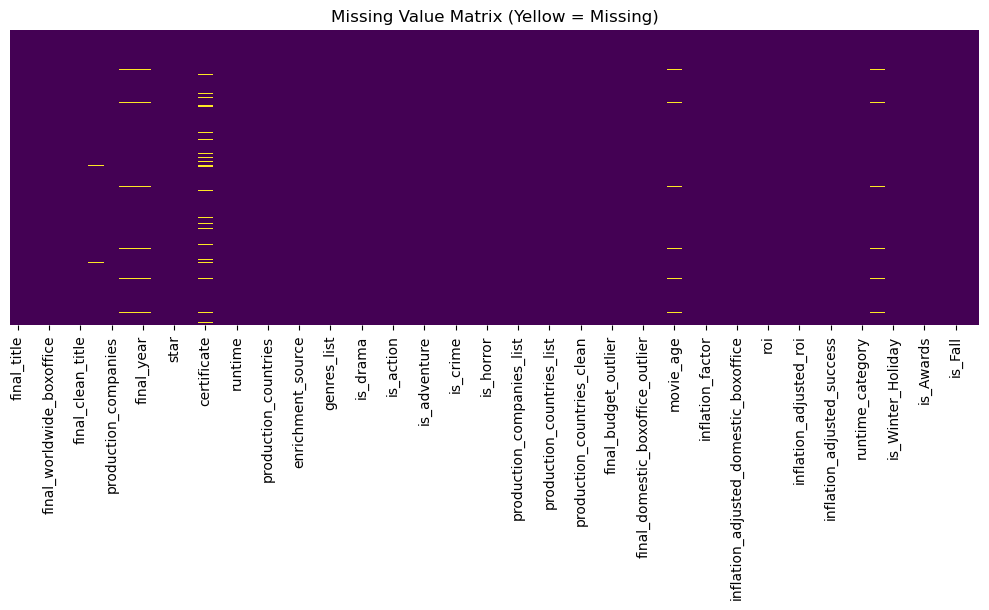

In [206]:
final_data= final_df.copy()
print(f"Dataset shape: {final_data.shape}")
missing = final_data.isna().mean().sort_values(ascending=False)
print("\nMissing values by column (%):")
print(missing.apply(lambda x: f"{x:.2%}"))

plt.figure(figsize=(10, 6))
sns.heatmap(final_data.isna(), yticklabels=False, cbar=False, cmap='viridis')
plt.tight_layout()
plt.title('Missing Value Matrix (Yellow = Missing)')
plt.show()

In [207]:
# Replace 'nan' values with 'Unknown' and set count to 0 
is_nan_company = final_data['production_companies_list'].apply(lambda x: isinstance(x, list) and len(x) == 1 and (x[0] == 'nan' or pd.isna(x[0])))
final_data.loc[is_nan_company, 'production_companies_list'] = final_data.loc[is_nan_company, 'production_companies_list'].apply(lambda x: ['Unknown'])
final_data.loc[is_nan_company, 'production_companies_count'] = 0
final_data.to_csv(r"C:\Users\divya\OneDrive\Documents\GitHub\spring-2025-greenlight\Praneed(EDA&Preprocessing)\final_data.csv",index=False)

columns_to_remove = [
    '_merge',           
    'final_title',      
    'genres',           
    'production_companies',  
    'production_countries',  
    'certificate',      
    'title_year',       
    'movie_age',        
    'genres_list'       
]

final_data = final_data.drop(columns=columns_to_remove, errors='ignore')

Dataset shape: (6822, 53)

Missing values by column (%):
release_date                              0.82%
final_year                                0.82%
release_month                             0.82%
imdb_id                                   0.15%
final_budget                              0.00%
roi                                       0.00%
certificate_clean                         0.00%
final_budget_outlier                      0.00%
runtime_outlier                           0.00%
final_domestic_boxoffice_outlier          0.00%
final_worldwide_boxoffice_outlier         0.00%
decade                                    0.00%
inflation_factor                          0.00%
inflation_adjusted_budget                 0.00%
inflation_adjusted_domestic_boxoffice     0.00%
inflation_adjusted_worldwide_boxoffice    0.00%
inflation_adjusted_roi                    0.00%
profit                                    0.00%
production_countries_count                0.00%
inflation_adjusted_profit      

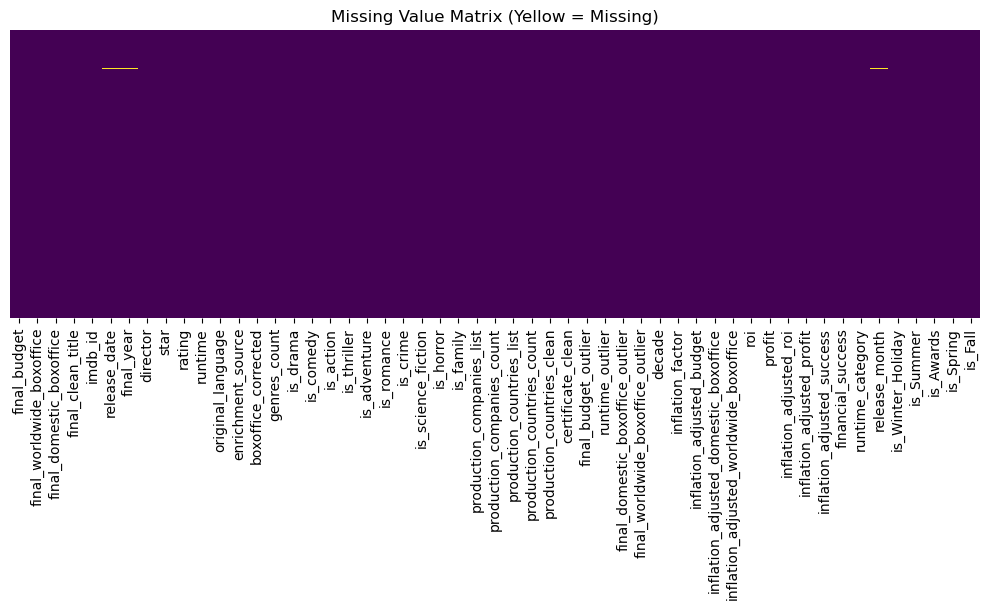

In [208]:
print(f"Dataset shape: {final_data.shape}")
missing = final_data.isna().mean().sort_values(ascending=False)
print("\nMissing values by column (%):")
print(missing.apply(lambda x: f"{x:.2%}"))

plt.figure(figsize=(10, 6))
sns.heatmap(final_data.isna(), yticklabels=False, cbar=False, cmap='viridis')
plt.tight_layout()
plt.title('Missing Value Matrix (Yellow = Missing)')
plt.show()

In [209]:
final_data.to_csv(r"C:\Users\divya\OneDrive\Documents\GitHub\spring-2025-greenlight\Praneed(EDA&Preprocessing)\final_data.csv",index=False)